In [1]:
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras

In [2]:
def imread(path):
    return cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

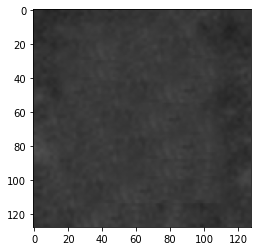

In [3]:
bgframe = imread('train_bgframe.png')
plt.imshow(bgframe)
plt.show()

In [6]:
paths = glob.glob('images/train/*/*.png')
len(paths)

18000

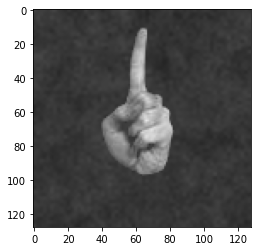

In [12]:
fgframe = imread(paths[0])
plt.imshow(fgframe)
plt.show()

In [60]:
fgframe.shape

(128, 128, 3)

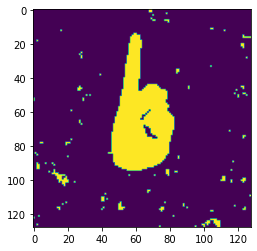

In [50]:
fgframe = imread(paths[1])
history = 10
bgsub = cv2.createBackgroundSubtractorMOG2(history=history, detectShadows=False)
plt.imshow(bgsub.apply(imread('train_bgframe1.png')))
plt.imshow(bgsub.apply(imread('train_bgframe2.png')))
plt.imshow(bgsub.apply(imread('train_bgframe3.png')))
plt.imshow(bgsub.apply(imread('train_bgframe4.png')))
plt.imshow(bgsub.apply(imread('train_bgframe5.png')))
plt.imshow(bgsub.apply(fgframe))

In [7]:
def preprocess_frame(frame):
    bgsub = cv2.createBackgroundSubtractorMOG2(detectShadows=False)
    bgsub.apply(imread('train_bgframe1.png'))
    bgsub.apply(imread('train_bgframe2.png'))
    bgsub.apply(imread('train_bgframe3.png'))
    bgsub.apply(imread('train_bgframe4.png'))
    bgsub.apply(imread('train_bgframe5.png'))
    mask = bgsub.apply(frame)
#     return mask
    return np.expand_dims(mask, axis=2)
#     return cv2.bitwise_and(frame, frame, mask=mask)

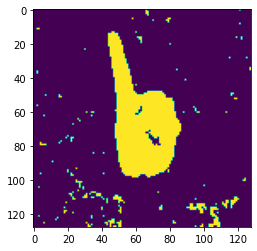

(128, 128, 1)

In [8]:
frame = preprocess_frame(imread(paths[5]))
plt.imshow(frame)
plt.show()
frame.shape

In [9]:
sample = random.sample(paths, 1000)
X = np.array([preprocess_frame(imread(path)) for path in sample])
Y = np.array([int(path.split('_')[1][:1]) for path in sample])
X.shape, Y.shape

((1000, 128, 128, 1), (1000,))

In [10]:
from collections import Counter
Counter(Y)

Counter({0: 167, 1: 164, 4: 193, 2: 155, 5: 166, 3: 155})

In [181]:
np.savez('bgdata', X=X, Y=Y)

In [184]:
npzfile = np.load('bgdata.npz')
X, Y = npzfile['X'], npzfile['Y']
X.shape, Y.shape

((1000, 128, 128, 1), (1000,))

In [192]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y)
Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((750, 128, 128, 1), (750,), (250, 128, 128, 1), (250,))

In [11]:
Xtrain, Ytrain = X, Y

In [12]:
model = keras.Sequential([
    keras.layers.Conv2D(32, 3, input_shape=(128, 128, 1)),
    keras.layers.AveragePooling2D(3),
    keras.layers.Conv2D(64, 3),
    keras.layers.MaxPooling2D(3),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(6, activation='softmax'),
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

2022-03-04 18:29:59.622105: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-03-04 18:29:59.646941: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1700840000 Hz
2022-03-04 18:29:59.647387: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55bb5e91adb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-03-04 18:29:59.647414: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-03-04 18:29:59.647589: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
average_pooling2d (AveragePo (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10816)             43264     
_________________________________________________________________
dense (Dense)                (None, 32)                3

In [123]:
data_dir = 'manual'
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=360,
    horizontal_flip=True,
    zoom_range=0.2,
)
flow_params = {
    'class_mode': 'sparse',
    'color_mode': 'grayscale',
    'target_size': (128, 128),
#     'batch_size': batch_size,
}
test_it = datagen.flow_from_directory(data_dir, **flow_params)

Found 30 images belonging to 6 classes.


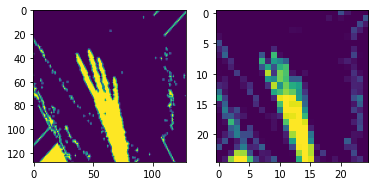

In [122]:
Xtrain, _ = test_it.next()
_, (ax1, ax2) = plt.subplots(1, 2)
X = Xtrain[0]
ax1.imshow(X)
ax2.imshow(keras.layers.AveragePooling2D(5)(Xtrain)[0])
plt.show()

In [126]:
model = keras.Sequential([
    keras.layers.AveragePooling2D(3, input_shape=(128, 128, 1)),
    keras.layers.Conv2D(32, 3),
    keras.layers.Conv2D(64, 3),
    keras.layers.MaxPooling2D(3),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(6, activation='softmax'),
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d_35 (Averag (None, 42, 42, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 40, 40, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 38, 38, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 9216)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 9216)              36864     
_________________________________________________________________
dense_12 (Dense)             (None, 32)               

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1 steps, validate for 1 steps
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.7540 - accuracy: 0.2333 - val_loss: 9.6925 - val_accuracy: 0.2333
Epoch 2/100
1/1 [==============================] - 1s 655ms/step - loss: 1.7724 - accuracy: 0.2333 - val_loss: 13.6037 - val_accuracy: 0.2000
Epoch 3/100
1/1 [==============================] - 1s 775ms/step - loss: 1.9333 - accuracy: 0.3333 - val_loss: 10.5220 - val_accuracy: 0.2000
Epoch 4/100
1/1 [==============================] - 1s 858ms/step - loss: 1.6784 - accuracy: 0.3333 - val_loss: 10.5600 - val_accuracy: 0.1667
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 1.4466 - accuracy: 0.4000 - val_loss: 13.3570 - val_accuracy: 0.1667
Epoch 6/100
1/1 [==============================] - 1s 936ms/step - loss: 1.3319 - accuracy: 0.3667 - val_loss: 12.2225 - val_accuracy: 0.1667
Epoch 7/100
1/1 [==============================] - 1s 997ms/step 

Epoch 58/100
1/1 [==============================] - 1s 721ms/step - loss: 0.4510 - accuracy: 0.8333 - val_loss: 2.8680 - val_accuracy: 0.4333
Epoch 59/100
1/1 [==============================] - 1s 717ms/step - loss: 0.4238 - accuracy: 0.8333 - val_loss: 2.7478 - val_accuracy: 0.4667
Epoch 60/100
1/1 [==============================] - 1s 684ms/step - loss: 0.4416 - accuracy: 0.8000 - val_loss: 3.1604 - val_accuracy: 0.4333
Epoch 61/100
1/1 [==============================] - 1s 618ms/step - loss: 0.4291 - accuracy: 0.8667 - val_loss: 2.8478 - val_accuracy: 0.5333
Epoch 62/100
1/1 [==============================] - 1s 643ms/step - loss: 0.3720 - accuracy: 0.9333 - val_loss: 3.0073 - val_accuracy: 0.5000
Epoch 63/100
1/1 [==============================] - 1s 600ms/step - loss: 0.2711 - accuracy: 0.9667 - val_loss: 2.9099 - val_accuracy: 0.5000
Epoch 64/100
1/1 [==============================] - 1s 655ms/step - loss: 0.4648 - accuracy: 0.8667 - val_loss: 2.6772 - val_accuracy: 0.6000
Epoch 

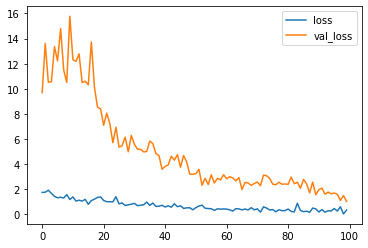

In [127]:
history = model.fit(test_it, validation_data=test_it, epochs=100)
df = pd.DataFrame(history.history)
df[['loss', 'val_loss']].plot()
plt.show()

In [128]:
model.save('manualmodel')

INFO:tensorflow:Assets written to: manualmodel/assets


In [49]:
history = model.fit(Xtrain, Ytrain, validation_data=test_it, epochs=7)
df = pd.DataFrame(history.history)
df[['loss', 'val_loss']].plot()
plt.show()

  ...
    to  
  ['...']
Train on 1000 samples, validate for 1 steps
Epoch 1/7
1000/1000 [==============================] - 13s 13ms/sample - loss: 0.1079 - accuracy: 0.9660 - val_loss: 10.7232 - val_accuracy: 0.2333
Epoch 2/7
1000/1000 [==============================] - 12s 12ms/sample - loss: 0.0524 - accuracy: 0.9820 - val_loss: 7.7201 - val_accuracy: 0.3000
Epoch 3/7
1000/1000 [==============================] - 12s 12ms/sample - loss: 0.0101 - accuracy: 0.9990 - val_loss: 10.1586 - val_accuracy: 0.2333
Epoch 4/7
1000/1000 [==============================] - 12s 12ms/sample - loss: 0.0069 - accuracy: 0.9990 - val_loss: 7.4825 - val_accuracy: 0.3000
Epoch 5/7
 384/1000 [==========>...................] - ETA: 8s - loss: 0.0034 - accuracy: 1.0000

KeyboardInterrupt: 

In [235]:
model.save('bgmodel')

INFO:tensorflow:Assets written to: bgmodel/assets
